# Predicting COVID-19 Using CT Scans

## Load the Data

In [1]:
## Imports ## 

import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn import metrics
from skimage import exposure

import tensorflow as tf
from tensorflow.keras import backend as K, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.vgg16 import VGG16

In [2]:
#Check if there's a GPU available 
tf.config.experimental.list_physical_devices('GPU')

[]

In [3]:
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1,len(loss)+1)

    plt.figure(figsize = (15,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, color = 'orange', label='Training Loss')
    plt.plot(epochs, val_loss, color = 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.legend()
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    plt.subplot(1,2,2)
    plt.plot(epochs, acc, color = 'orange', label='Training Accuracy')
    plt.plot(epochs, val_acc, color = 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('epoch')
    plt.legend()
    
    plt.show();

Load the image data:

In [4]:
data = []
file_list = []
y = []

for png in os.listdir("../data/CT_COVID"):
    pic = plt.imread("../data/CT_COVID/" + png, 0)
    data.append(pic)
    file_list.append(png)
    y.append(1)

for png in os.listdir("../data/CT_NonCOVID"):
    pic = plt.imread("../data/CT_NonCOVID/" + png, 0)
    data.append(pic)
    file_list.append(png)
    y.append(0)

In [5]:
metadata = pd.read_excel("../data/COVID-CT-MetaInfo.xlsx", header = None, names = ['file','patient','column3','note'])

Look at the data:

Case and Control Counts: 
Case
0    397
1    349
Name: Case, dtype: int64


Example Image with COVID: 


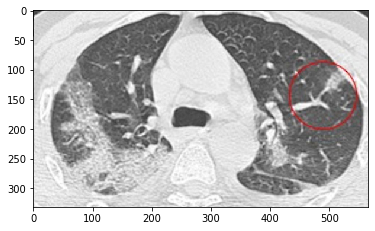

Example Image without COVID: 


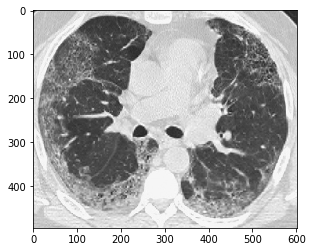

In [6]:
print("Case and Control Counts: ")
print(pd.DataFrame(y, columns = ['Case']).groupby("Case").Case.count())

print("\n")

print("Example Image with COVID: ")
plt.imshow(data[1]); plt.show();

print("Example Image without COVID: ")
plt.imshow(data[501], cmap = 'gray'); plt.show();

In [7]:
metadata.head() #note: checked that these are in the same order as the file list; for covid-19 patients only 

,file,patient,column3,note
0,2020.01.24.919183-p27-132.png,Patient 1,NaN,['Figure 1. Chest radiographs of patient 1. a....
1,2020.01.24.919183-p27-133.png,Patient 1,NaN,['Figure 1. Chest radiographs of patient 1. a....
2,2020.01.24.919183-p27-134.png,Patient 1,NaN,['Figure 1. Chest radiographs of patient 1. a....
3,2020.01.24.919183-p27-135.png,Patient 1,NaN,['Figure 1. Chest radiographs of patient 1. a....
4,2020.02.10.20021584-p6-52%0.png,Patient 2,NaN,['Figure 1. A 50-year-old man with 2019 novel ...


In [8]:
metadata.loc[metadata.patient == 'Patient 1'] #Some patients have multiple images.

,file,patient,column3,note
0,2020.01.24.919183-p27-132.png,Patient 1,NaN,['Figure 1. Chest radiographs of patient 1. a....
1,2020.01.24.919183-p27-133.png,Patient 1,NaN,['Figure 1. Chest radiographs of patient 1. a....
2,2020.01.24.919183-p27-134.png,Patient 1,NaN,['Figure 1. Chest radiographs of patient 1. a....
3,2020.01.24.919183-p27-135.png,Patient 1,NaN,['Figure 1. Chest radiographs of patient 1. a....


## Data Processing

Investigate the size of the images:

In [9]:
print("All images have different shapes, including # of channels: ")
print(data[1].shape)
print(data[2].shape)
print(data[3].shape)
print(data[4].shape)

#Get a list of all the sizes
shape = []
for img in data:
    shape.append(img.shape)

print(pd.DataFrame([len(s) for s in shape], columns = ['len']).groupby('len').size()) #There are 2-D and 3-D images

print((pd.DataFrame([s[0] for s in shape], columns = ['height'])).describe()) #avg 302, min 61
print((pd.DataFrame([s[1] for s in shape], columns = ['width'])).describe()) #avg 425, min 115

All images have different shapes, including # of channels: 
(332, 566, 4)
(366, 612, 4)
(551, 725, 4)
(541, 720, 4)
len
2     44
3    702
dtype: int64
            height
count   746.000000
mean    302.553619
std     145.210573
min      61.000000
25%     204.000000
50%     291.000000
75%     363.750000
max    1225.000000
             width
count   746.000000
mean    425.482574
std     188.546038
min     115.000000
25%     311.250000
50%     407.000000
75%     512.000000
max    1671.000000


All of the images need to be the same size. Use the average size of the image from the investigation above. Use high quality down-sampling filter to resize images. Also, turn all images to black and white.

In [10]:
image_dim = (300, 400) #use the averages for the dimensions

data_cleaned = []

for img in data:
    #First, take the mean of the 3rd dimension (channels) if it exists
    if len(img.shape) == 3:
        img = np.mean(img, axis = 2)
    
    #Using PIL Image processor, resize using high quality down-sampling filter 
    img = Image.fromarray(img)
    img = img.resize((image_dim[1], image_dim[0]), Image.ANTIALIAS)
    img = np.array(img)
    
    #Normalize image values
    img = img/255
    
    img[img > 1] = 1
    
    data_cleaned.append(img)

data_cleaned = np.array(data_cleaned)
data_cleaned = np.expand_dims(data_cleaned,axis = 3)

Take a look at a few images and confirm that we have not lost too much information.

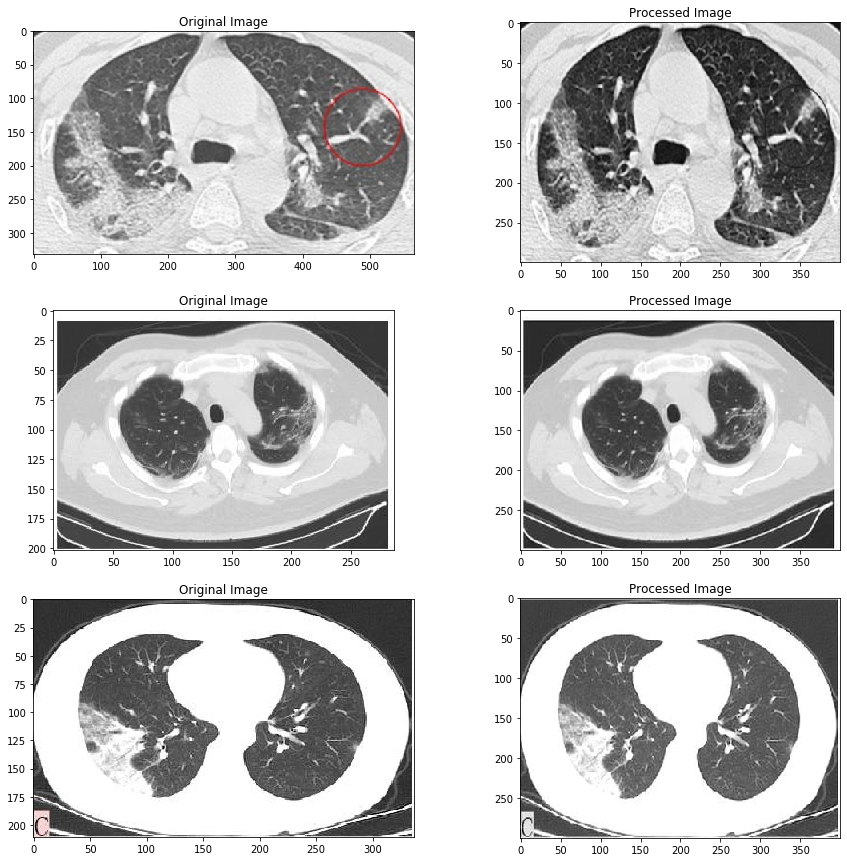

In [11]:

plt.figure(figsize = (15, 15))
plt.subplot(3,2,1)
plt.imshow(data[1], cmap = 'gray')
plt.title("Original Image")
plt.subplot(3,2,2)
plt.title("Processed Image")
plt.imshow(np.squeeze(data_cleaned[1]), cmap = 'gray')

plt.subplot(3,2,3)
plt.imshow(data[11], cmap = 'gray')
plt.title("Original Image")
plt.subplot(3,2,4)
plt.title("Processed Image")
plt.imshow(np.squeeze(data_cleaned[11]), cmap = 'gray')

plt.subplot(3,2,5)
plt.imshow(data[40], cmap = 'gray')
plt.title("Original Image")
plt.subplot(3,2,6)
plt.title("Processed Image")
plt.imshow(np.squeeze(data_cleaned[40]), cmap = 'gray')

plt.show();

Note that we can still see the ground glass opacities in the upper right (image 1), middle right (image 2) and bottom left (image 3).

## Data Augmentation

First, split into the test and training set. We only want to augment the training data.

In [12]:
data_train, data_val, y_train, y_val = train_test_split(data_cleaned, np.array(y),\
                                                        train_size = 0.75, random_state = 10)

In [13]:
print(str((y_val.sum() / len(y_val) )*100) + "% of our validation data is cases")

47.05882352941176% of our validation data is cases


In [14]:
print("Training Sample Sizes: ")
print(data_train.shape)
print(y_train.shape)
print("Validation Sample Sizes: ")
print(data_val.shape)
print(y_val.shape)

Training Sample Sizes: 
(559, 300, 400, 1)
(559,)
Validation Sample Sizes: 
(187, 300, 400, 1)
(187,)


Because we have a very small sample size, we want to augment our available data. We will flip all of the images horizontally and vertically, rotate randomly (with a maximum of 15 degrees, so we don't change the lung structure too much), and apply some whitening which will help with contrast.

In [15]:
datagen = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,  
    rotation_range = 15,
#     zca_whitening = True,
    fill_mode = 'nearest')

datagen.fit(data_train)

We also considered other data augmentation, such as zoom and shifting, but these methods did not seem appropriate given the structure of a lung CT scan, where all images will all be centered in the same location.

Let's take a look at our augmented images:

In [16]:
def visualize_augmented_images(image_num):
    img = data_train[image_num]
    img = img.reshape((1,300,400,1))

    i = 1
    plt.figure(figsize = (10,5))
    for batch in datagen.flow(img, batch_size=1):
        plt.subplot(2,2,i)
        imgplot = plt.imshow(image.array_to_img(batch[0]), cmap = 'gray')
        i += 1
        if i % 5 == 0:
            break

    plt.show();

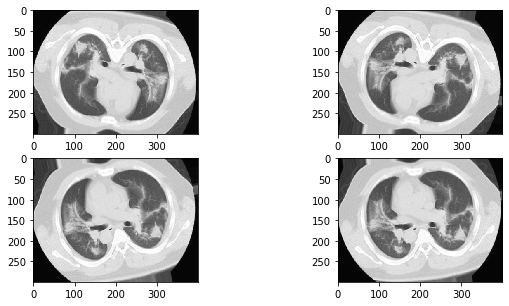

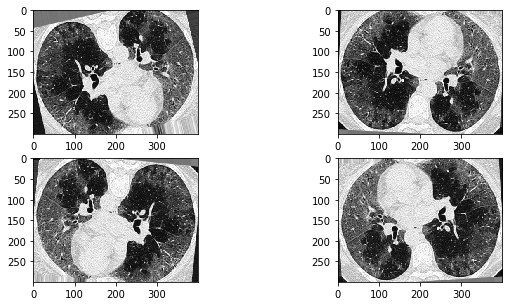

In [17]:
visualize_augmented_images(0)
visualize_augmented_images(30)

In [18]:
print("Training Sample Sizes: ")
print(data_train.shape)
print(y_train.shape)
print("Validation Sample Sizes: ")
print(data_val.shape)
print(y_val.shape)

Training Sample Sizes: 
(559, 300, 400, 1)
(559,)
Validation Sample Sizes: 
(187, 300, 400, 1)
(187,)


## Train 3 Models

In this section, we train 3 models to detect COVID-19 in lung CT scans. The analysis, visualization, and discussion of our results can be found in the following section.

### Simple CNN

We first create a simple CNN. We use a similar architecture as we have used in the past for MNIST analyses, including 4 convolutional layers, with max pooling, a small dropout probability, and a sigmiod activation function. This model yields 74% accuracy. 

In [19]:
model_simple = Sequential(name = 'Simple_CNN')
model_simple.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(300, 400, 1)))
model_simple.add(MaxPooling2D((2, 2), padding = 'same'))
model_simple.add(Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model_simple.add(MaxPooling2D((2, 2), padding = 'same'))
model_simple.add(Conv2D(128, (3, 3), activation='relu', padding = 'same'))
model_simple.add(MaxPooling2D((2, 2)))
model_simple.add(Conv2D(128, (3, 3), activation='relu', padding = 'same'))
model_simple.add(MaxPooling2D((2, 2)))
model_simple.add(Flatten())
model_simple.add(Dropout(0.05))
model_simple.add(Dense(32, activation='relu'))
model_simple.add(Dense(1, activation='sigmoid'))

model_simple.summary()

model_simple.compile(optimizer = Adam(), loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "Simple_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 400, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 200, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 200, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 100, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 100, 128)      73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 50, 128)       0         
_________________________________________

In [106]:
history_simple = model_simple.fit(
    datagen.flow(data_train, y_train, batch_size=16),
    epochs=10,
    validation_data=(data_val, y_val))

Train for 35 steps, validate on 187 samples
Epoch 1/10
35/35 [==============================] - 12s 329ms/step - loss: 0.6875 - accuracy: 0.5331 - val_loss: 0.6454 - val_accuracy: 0.6791
Epoch 2/10
35/35 [==============================] - 11s 311ms/step - loss: 0.6427 - accuracy: 0.6583 - val_loss: 0.6321 - val_accuracy: 0.6203
Epoch 3/10
35/35 [==============================] - 11s 305ms/step - loss: 0.6024 - accuracy: 0.6887 - val_loss: 0.6010 - val_accuracy: 0.6845
Epoch 4/10
35/35 [==============================] - 11s 303ms/step - loss: 0.5947 - accuracy: 0.6959 - val_loss: 0.6075 - val_accuracy: 0.5936
Epoch 5/10
35/35 [==============================] - 11s 310ms/step - loss: 0.5586 - accuracy: 0.7209 - val_loss: 0.5158 - val_accuracy: 0.7273
Epoch 6/10
35/35 [==============================] - 11s 308ms/step - loss: 0.5277 - accuracy: 0.7603 - val_loss: 0.5446 - val_accuracy: 0.7219
Epoch 7/10
35/35 [==============================] - 11s 308ms/step - loss: 0.5134 - accuracy: 0.75

In [107]:
#Save weights - only run this if you want to overwrite previous saved weights!
# model_simple.save_weights('models/simple_model')

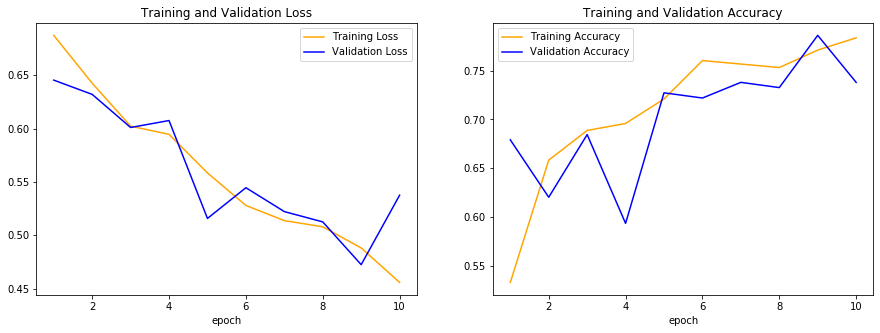

In [108]:
plot_training_history(history_simple)

In [20]:
#Load weights
model_simple.load_weights('models/simple_model')

### Pre-Trained Model Using VGG

Because our sample is so small, we believed we could benefit from using a pretrained model for the convolutional base. VGG16 is a convolutional neural network model created by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”. The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes. 

For our purposes, we froze the first 4 convolutional blocks, and trained the last convolutional block. Each block contains three convolutional layers and one max pooling layer. We also added a dense layer to the end, with 2 filters and softmax activation function, so as to classify our images as cases or controls. This model immediately outperforms the vanilla CNN with an increase to 84% accuracy.

In [21]:
# load VGG and concatenate input images into 3 channels because vgg takes rgb images
img_input = Input(shape=(300, 400, 1))
vgg_model = VGG16(weights="imagenet", include_top=False, 
                  input_tensor=Concatenate()([img_input, img_input, img_input]))

In [22]:
# add a global spatial average pooling layer and a dense layer to classify 2 classes
x = vgg_model.output
x = Conv2D(64, (3, 3), activation='relu', padding = 'same')(x)
x = MaxPooling2D((2, 2), padding = 'same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding = 'same')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dropout(0.05)(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# new model to train
pretrain_vgg_model = Model(inputs=vgg_model.input, outputs=predictions, name = "VGG_Pretrain")

# freeze many convolutional VGG layers: only train the last block
for layer in vgg_model.layers:
    layer.trainable = False

pretrain_vgg_model.compile(optimizer=Adam(), loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])
    
pretrain_vgg_model.summary()


Model: "VGG_Pretrain"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 400, 1) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 300, 400, 3)  0           input_1[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 300, 400, 64) 1792        concatenate[0][0]                
_______________________________________________________________________________________

In [87]:
#Train model
history_vgg = pretrain_vgg_model.fit(
    datagen.flow(data_train, tf.keras.utils.to_categorical(y_train), batch_size=16),
    epochs=10,
    validation_data=(data_val, tf.keras.utils.to_categorical(y_val)))

Train for 35 steps, validate on 187 samples
Epoch 1/10
35/35 [==============================] - 22s 628ms/step - loss: 0.6536 - accuracy: 0.6619 - val_loss: 0.4746 - val_accuracy: 0.7701
Epoch 2/10
35/35 [==============================] - 21s 587ms/step - loss: 0.4650 - accuracy: 0.7549 - val_loss: 0.4461 - val_accuracy: 0.7861
Epoch 3/10
35/35 [==============================] - 21s 589ms/step - loss: 0.4756 - accuracy: 0.7800 - val_loss: 0.5008 - val_accuracy: 0.7433
Epoch 4/10
35/35 [==============================] - 21s 588ms/step - loss: 0.4230 - accuracy: 0.8193 - val_loss: 0.4592 - val_accuracy: 0.7861
Epoch 5/10
35/35 [==============================] - 21s 591ms/step - loss: 0.4115 - accuracy: 0.8086 - val_loss: 0.4663 - val_accuracy: 0.7647
Epoch 6/10
35/35 [==============================] - 21s 589ms/step - loss: 0.4286 - accuracy: 0.8086 - val_loss: 0.4490 - val_accuracy: 0.7754
Epoch 7/10
35/35 [==============================] - 21s 588ms/step - loss: 0.3691 - accuracy: 0.83

In [88]:
#Save weights - only run this if you want to overwrite previous saved weights!
# pretrain_vgg_model.save_weights('models/VGG_model')

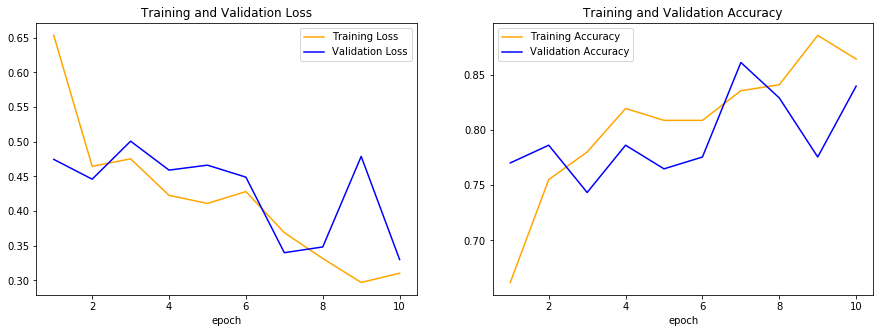

In [89]:
plot_training_history(history_vgg)

In [23]:
pretrain_vgg_model.load_weights('models/VGG_model')

### Pre-Train model using NiftyNet

We also felt that it would be benefitial to pretrain using a model that is specific to medical imaging data. NiftyNet is an open source convolutional neural net platform designed for sharing networks and pre-trained models. As stated on their website, "NiftyNet is a consortium of research organisations (BMEIS -- School of Biomedical Engineering and Imaging Sciences, King's College London; WEISS -- Wellcome EPSRC Centre for Interventional and Surgical Sciences, UCL; CMIC -- Centre for Medical Image Computing, UCL; HIG -- High-dimensional Imaging Group, UCL), where BMEIS acts as the consortium lead."

In terminal

Here, we see data, extension, and models. We have'data', which directly stores example image inputs, the 'models' directory that stores trained model weights, and the 'extensions' directory that stores Python implementation of networks, loss functions, new applications, etc.

In [24]:
#Code from:
#https://github.com/NifTK/NiftyNet/issues/254

import tensorflow as tf
import os
import pdb
from niftynet.io.image_reader import ImageReader
from niftynet.engine.sampler_resize_v2 import ResizeSampler
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"]='1'


##### Address of the model to be restored
check_point_location='/niftynet/models/dense_vnet_abdominal_ct/models/model.ckpt-3000'
#####

##### Create a sampler
data_param = {'image': {'path_to_search': '~/niftynet/data/dense_vnet_abdominal_ct',
                        'filename_contains': 'CT', 'spatial_window_size': (144, 144, 144)}}


reader = ImageReader().initialise(data_param)

sampler = ResizeSampler(
    reader=reader,
    window_sizes=(144, 144, 144),
    batch_size=1,
    shuffle=True,
    queue_length=35)

#####

with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False)) as sess:                                                                                                                                                      
    from niftynet.network.dense_vnet import DenseVNet                                                                                                                                                                                                       
    data_dict = sampler.pop_batch_op()                                                                                                                                                                                                                      
    net_logits = DenseVNet(num_classes=9)(data_dict['image'])                                                                                                                                                                                               
    saver = tf.train.Saver()                                                                                                                                                                                                                                
    saver.restore(sess, check_point_location)                                                                                                                                                                                                               
                                                                                                                                                                                                                                                            
    net_logits = sess.run(net_logits)                                                                                                                                                                                                                       
    print(net_logits.shape)  


INFO:tensorflow:TensorFlow version 1.15.2

CRITICAL:tensorflow:Optional Python module SimpleITK not found, please install SimpleITK and retry if the application fails.
INFO:tensorflow:Available Image Loaders:
['nibabel', 'opencv', 'skimage', 'pillow', 'dummy'].






INFO:niftynet: Optional Python module SimpleITK not found, please install SimpleITK and retry if the application fails.
INFO:niftynet: Optional Python module SimpleITK version None not found, please install SimpleITK-None and retry if the application fails.


CRITICAL:niftynet: data input folder "~/niftynet/data/dense_vnet_abdominal_ct" not found, did you maybe forget to download data?

CRITICAL:niftynet: Empty filename lists, please check the csv files (removing csv_file keyword if it is in the config file to automatically search folders and generate new csv files again).

Please note in the matched file names, each subject id are created by removing all keywords listed `filename_contains` in the config.
E.g., `filename_

OSError: 

## Analysis and Discussion of Predictions

In [138]:
### Plot the training and test ROC Curves ###
def plot_roc(model, categorical_ys):
    #Metrics for Testing Data
    if categorical_ys == 0:
        probs_test = model.predict(data_val)
    else:
        probs_test = model.predict(data_val)[:,1]
    preds_test = probs_test.reshape(-1)
    fpr_test, tpr_test, threshold_test = metrics.roc_curve(y_val, preds_test)
    roc_auc_test = metrics.auc(fpr_test, tpr_test)

    #Metrics for Training Data
    if categorical_ys == 0:
        probs_train = model.predict(data_train)
    else:
        probs_train = model.predict(data_train)[:,1]
    preds_train = probs_train.reshape(-1)
    fpr_train, tpr_train, threshold_train = metrics.roc_curve(y_train, preds_train)
    roc_auc_train = metrics.auc(fpr_train, tpr_train)

    #Plot
    plt.title('ROC Curve')
    plt.plot(fpr_test, tpr_test, 'b', label = 'Test AUC = %0.2f' % roc_auc_test)
    plt.plot(fpr_train, tpr_train, 'g', label = 'Train AUC = %0.2f' % roc_auc_train)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Sensitivity: True Positive Rate')
    plt.xlabel('1-Specificity: False Positive Rate')
    plt.show();

    #Training and Test AUCs
    print('Test AUC = %0.4f' % roc_auc_test)
    print('Train AUC = %0.4f' % roc_auc_train)

In [176]:
def sensitivity_specificity(threshold_perc, probs_test, y_val):
    #Sensitivity
    print("The sensitivy at threshold percentage = " + str(threshold_perc) + " is : " + \
          str(round(np.sum(((probs_test >= threshold_perc) & (y_val == 1))) / np.sum((y_val == 1)),4)))
    #Specificity
    print("The specificity at threshold percentage = " + str(threshold_perc) + " is : " + \
          str(round(np.sum(((probs_test < threshold_perc) & (y_val == 0))) / np.sum((y_val == 0)),4)))

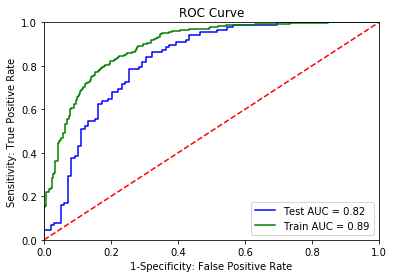

Test AUC = 0.8244
Train AUC = 0.8913


In [139]:
plot_roc(model_simple, categorical_ys = 0)

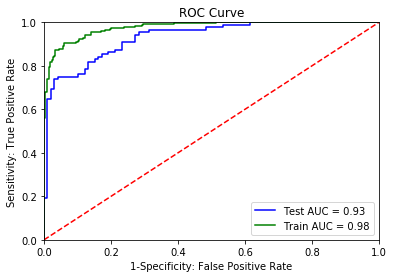

Test AUC = 0.9316
Train AUC = 0.9765


In [140]:
plot_roc(pretrain_vgg_model, categorical_ys = 1)

NOTES FOR DISCUSSION:

73.80% validations accuracy and 0.8244 test AUC for for simple CNN
83.95% validations accuracy and 0.9316 test AUC for pretrained CNN

the simple CNN is benefited by using the convolutional base from the VGG16 pretrained CNN. This is because the basic features, such as horizontal lines and basic shapes, will be the same regardless of wehter you're looking at ImageNet or lung cancer CT images. we then layered on top a few more convolutional layers and max pooling layers, using a similar construction as our simple CNN. this achieves 85% accuracy and 0.9316 AUC. 

Going forward, we will focus on the VGG16 pretrained CNN, as that outperforms the simple CNN.

When training models for clinical use, it is common practice to select threshold for predicting a case based on a sensitivity and specificity metric. Accuracy is relatively less important. Context is very important for this assessment. For the purposes of our analysis, because we are concerned with a diagnostic medical diagnosis, we would choose a high sensitivity (i.e., high true positive rate) and accept a lower specificity. This would result in more false positives (i.e., P(T+|D-) is high) but fewer false negatives (i.e., P(T-|D+ is low). We want this because a false negative is more harmful than a false positive; if someone must self-quarantine for a false alarm, that is less detrimental than a person failing to self-quarantine when they are truly infected. 

We observe that the default cutoff for the threshold to predict a case (p = 0.5) results in 0.8522 sensitivity and 0.8282 specificity. By decreasing the cutoff threshold to p = 0.25

In [177]:
probs_test = pretrain_vgg_model.predict(data_val)[:,1]
preds_test = probs_test.reshape(-1)
fpr_test, tpr_test, threshold_test = metrics.roc_curve(y_val, preds_test)

# pd.DataFrame(pd.np.column_stack([threshold_test, tpr_test, 1-fpr_test]), 
#              columns = ['threshold','sensitivity','specificity'])

sensitivity_specificity(0.5, probs_test, y_val)
sensitivity_specificity(0.25, probs_test, y_val)

The sensitivy at threshold percentage = 0.5 is : 0.8523
The specificity at threshold percentage = 0.5 is : 0.8283
The sensitivy at threshold percentage = 0.25 is : 0.9432
The specificity at threshold percentage = 0.25 is : 0.7273


## Visualizing the Model

First, we visualize some of the intermediate activation layers:

In [23]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(np.expand_dims(data_val[1],0))

first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 300, 400, 64)


In [24]:
activations[1].shape

(1, 150, 200, 64)

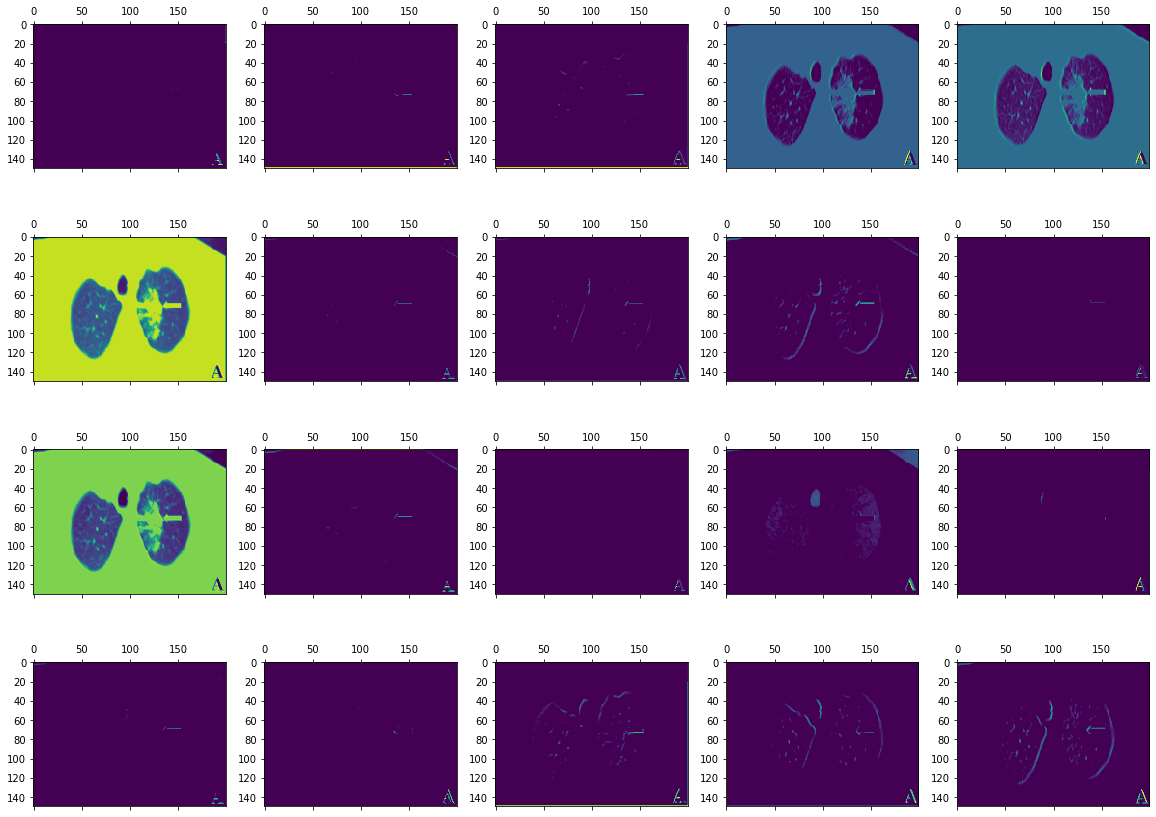

In [25]:
plt.figure(figsize = (20,15))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.matshow(activations[1][0, :, :, i], cmap = 'viridis', fignum = False)

plt.show();

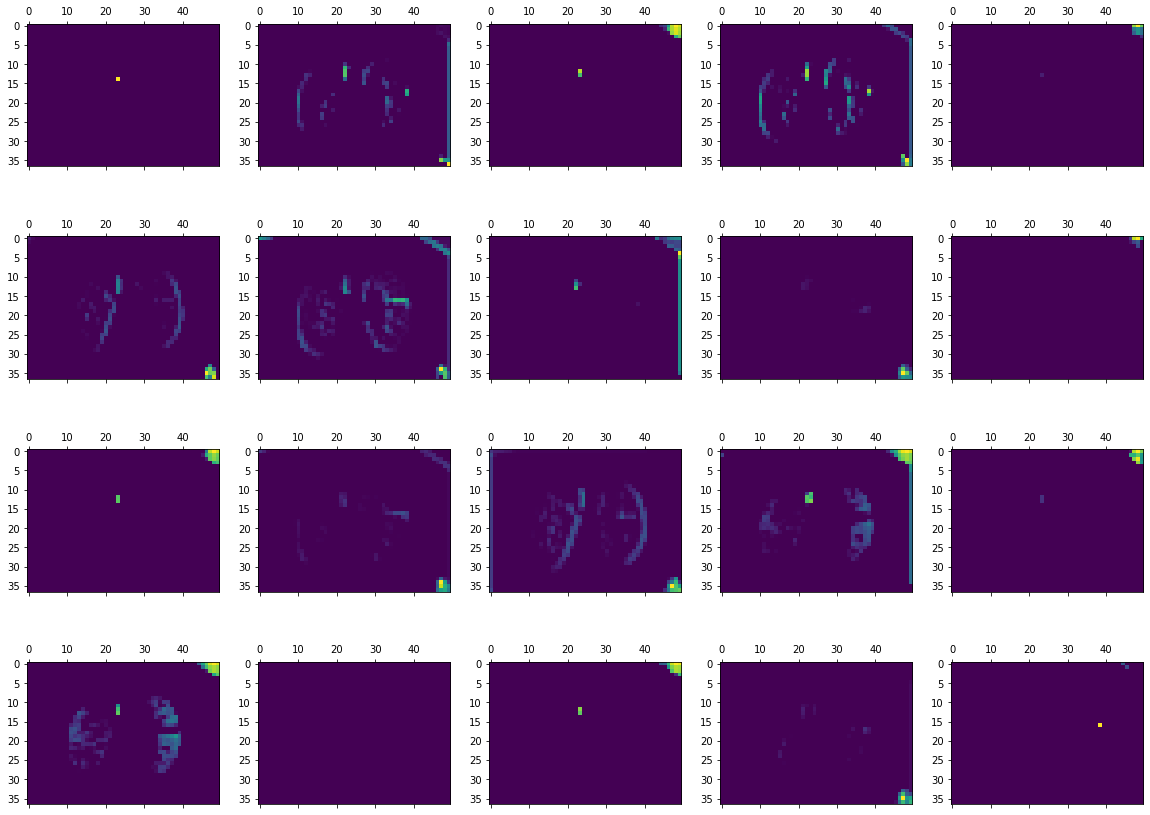

In [26]:
plt.figure(figsize = (20,15))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.matshow(activations[5][0, :, :, i], cmap = 'viridis', fignum = False)

plt.show();

Let's look with Grad-CAM and Saliency Maps

In [107]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from matplotlib import cm

In [172]:
# Define loss function
loss = lambda x: K.mean(x[:, 0])

def og_sal_grad(image_id):
    # Define modifier to replace a softmax function of the last layer to a linear function.
    def model_modifier(m):
        m.layers[-1].activation = tf.keras.activations.linear

    # Create Saliency object
    saliency = Saliency(model, model_modifier)

    # Generate saliency map with smoothing that reduce noise by adding noise
    saliency_map = saliency(loss, data_val[image_id].astype(float), smooth_samples=20)
    saliency_map = normalize(saliency_map)

    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})

    img = data_val[image_id,:,:,:]
    img_batch = (np.expand_dims(img,0))

    # from matplotlib import cm
    # from tf_keras_vis.gradcam import Gradcam

    # Create Gradcam object
    gradcam = Gradcam(model, model_modifier)

    # Generate heatmap with GradCAM
    cam = gradcam(loss, img_batch.astype(float))
    cam = normalize(cam)


    #Plot
    plt.subplot(1,3,1)
    plt.title("Original Image")
    plt.imshow(np.squeeze(data_val[image_id]), cmap = 'gray')
    plt.subplot(1,3,2)
    plt.title("Saliency Map")
    plt.imshow(saliency_map[0], cmap='YlOrBr');
    plt.subplot(1,3,3)

    
    plt.title("GradCAM")
    for i in range(len(cam)):
        heatmap = np.uint8(tf.cast(cm.jet(cam[i])[..., :3] * 255, tf.float32))
        plt.imshow(np.squeeze(img))
        plt.imshow(heatmap, cmap='YlOrBr', alpha=0.6)

Prediction is: 0


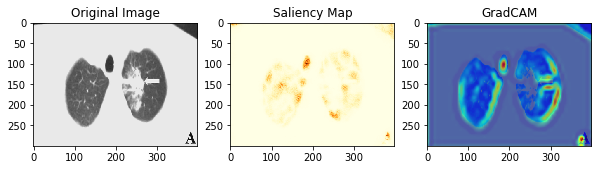

In [173]:
og_sal_grad(1)

#Do this for cases and controls - ones we got right and ones we got wrong 

#put in some info on saliency maps and gradcam from documentation/labs

#What is the prediction for this image?
predictions_single = model.predict(img_batch)
print(f'Prediction is: {np.argmax(predictions_single[0])}') 
#add "with probability..." How confident is it that it's ______

# Nifty Net

Make sure to have the correct installations:
    - pip install "tensorflow==1.15.*"
    - pip install niftynet
    

NiftyNet citation:
    
    E. Gibson*, W. Li*, C. Sudre, L. Fidon, D. I. Shakir, G. Wang, Z. Eaton-Rosen, R. Gray, T. Doel, Y. Hu, T. Whyntie, P. Nachev, M. Modat, D. C. Barratt, S. Ourselin, M. J. Cardoso† and T. Vercauteren† (2018) NiftyNet: a deep-learning platform for medical imaging, Computer Methods and Programs in Biomedicine. DOI: 10.1016/j.cmpb.2018.01.025